# Applying Artificial Neural Nets to Materials Problems

##### What works, what's easy, what's hard and how to think of ANNs for analyzing materials systems

At the top we have the code to run the code for the rest of the notebook.
The reader can skip passed the code for now, then return to it as desired.

In [1]:
#Import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#Ignore matplotlib warnings.
import warnings
warnings.filterwarnings("ignore")

#Set up displaying images.
from IPython.display import Image
from IPython.display import display

In [2]:
def visualize_lattice(array1, array2, state1, state2):
    #Close the plot so new plots will be created.
    plt.close()
    #Dictionary to fill in circle based on the spin.
    color_dict = {-1:'k',1:'none'}
    #Reshape the array for the plot
    array1 = np.array([array1]).reshape(32,16)
    array2 = np.array([array2]).reshape(32,16)
    #Assign the fill based off of spin.
    colors1 = [color_dict[array1[j, i]] for i in range(0,16) for j in range(0,32)]
    colors2 = [color_dict[array2[j, i]] for i in range(0,16) for j in range(0,32)]
    #Use indices as the spin locations
    indices = np.array([[j, i] for i in range(0,16) for j in range(0,32)])
    plt.figure(figsize=(11,6))
    
    #Create subplots for the two different images.
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    
    #Plot the even rows for the first system.
    ax1.scatter(indices[::2,1], -indices[::2,0], facecolor = colors1[::2], edgecolor = 'k')
    #Plot the odd rows with an x-offset for better visualization
    ax1.scatter(indices[1::2,1]+0.5, -indices[1::2,0], facecolor = colors1[1::2], edgecolor = 'k')
    
    #Plot the even rows for the second system.
    ax2.scatter(indices[::2,1], -indices[::2,0], facecolor = colors2[::2], edgecolor = 'k')
    #Plot the odd rows with an x-offset for better visualization
    ax2.scatter(indices[1::2,1]+0.5, -indices[1::2,0], facecolor = colors2[1::2], edgecolor = 'k')
    
    #Turn off the border.
    ax1.axis('off')
    ax2.axis('off')
    
    #Label plot with its state.
    ax1.set_title(state1, fontsize = 24)
    ax2.set_title(state2, fontsize = 24)
    
    #Show the plot.
    plt.show()

In [155]:
def check_vertice_energies(vertices, model):
    #Assume things are okay to start with
    energies_okay = True
    #Make sure there are the right number or vertices/plaquettes
    if len(vertices) != 256:
        energies_okay = False
        print("Wrong number of vertices/plaquettes found!")
    if model == 'gauge':
        #The only allowed plaquette energies are +1 and -1
        values = [i for i in list(set(vertices)) if i not in [-1, 1]]
        if len(values) > 0:
            print("Non -1, 1 value found in plaquettes!")
            #If there are any plaquettes not +1 or -1 raise error.
            energies_okay = False
        #High energy plaquettes have to come in pairs,
        #check to see if there is somehow an odd number.
        number_high_energy = list(vertices).count(1)
        if number_high_energy % 2 != 0.0:
            #If odd number of high-energy plaquettes raise error
            print("Odd number of high-energy plaquettes found!")
            energies_okay = False
    elif model == 'square-ice':
        #The only allowable energies for vertices is 0, 4 and 16
        values = [i for i in list(set(vertices)) if i not in [0, 4, 16]]
        if len(values) > 0:
            print("Strange value found in vertices!")
            energies_okay = False
    else:
        #If the model isn't correctly specified raise error.
        print("\"{}\" not found!".format(model))
        energies_okay = False
    return energies_okay

def check_bond_values(bonds):
    bonds_okay = True
    #Make sure there are the correct number of bonds for
    #the non-periodic and periodic systems
    if len(bonds) != 512 and len(bonds) != 561:
        print("Wrong number of bonds found!")
        bonds_okay = False
    #the only allowable spins are +1 and -1, if a
    #different type is found, raise error
    values = [i for i in list(set(bonds)) if i not in [-1, 1]]
    if len(values) > 0:
        print("Wrong spin value found!")
        bonds_okay = False
    return bonds_okay

def get_energy(energy, model):
    size = 16
    #Create the mapping
    vertices_to_bonds_mapper, bonds_to_vertices_mapper = build_mappers(size)
    #Create an empty list in which to store the system's energy
    energies_list = []
    for system in energy:
        #Create the ising class
        ising = Ising(size = size, seed = np.random.randint(1000000), T=0.05, model=model)
        ising.get_mappers(vertices_to_bonds_mapper, bonds_to_vertices_mapper)
        ising.bonds = system
        #Set the bonds in the ising model to those from the system
        ising.apply_bonds()
        #Calculate the energy of the system with these bonds
        E = ising.vertices.sum()
        energies_list.append(E)
        #Check that there aren't any vertices or plaquettes with strange
        #energy values
        energies_okay = check_vertice_energies(ising.vertices, model = model)
        #Check that all the spins make sense
        bonds_okay = check_bond_values(ising.bonds)
        #If there is an error with the vertices or plaquettes raise an error
        if not energies_okay:
            print("Error found in vertices!")
            break
        #If there is an error with the bonds raise an error
        if not bonds_okay:
            print("Error found in bonds!")
            break
    return energies_list
            
def verify_inputs(high_energy, low_energy, model):
    #Calculate the average and standard devation to make sure
    #the ground and excited states are distince from eachother.
    lowEs = get_energy(low_energy, model=model)
    print("The ground state systems have a mean of {:.2f} +/- {:.2f}".format(np.mean(lowEs), np.std(lowEs)))
    highEs = get_energy(high_energy, model=model)
    print("The excited state systems have a mean of {:.2f} +/- {:.2f}".format(np.mean(highEs), np.std(highEs)))

In [111]:
def relu(x):
    #Rectified Linear unit
    return x.clip(0,np.amax(x))

def sigmoid(x):
    #Sigmoidal
    return 1/(1+np.exp(-1*x))

def tanh(x):
    #Hyperbolic Tangent
    return np.tanh(x)

def step(x):
    #Step function
    return np.array([0 if val < 0 else 1 for val in x])

def elu(x):
    #Exponential
    return np.array([(np.exp(val)-1) if val < 0 else val for val in x])
    
def plot_activation_functions(x):
    #Close the plot to avoid combining previously made plots
    plt.close()
    #Format the size so it is easier to see the plots
    plt.figure(figsize = (12,6))
    #Set up six subplots
    ax1 = plt.subplot(231)
    ax2 = plt.subplot(232)
    ax3 = plt.subplot(233)
    ax4 = plt.subplot(234)
    ax5 = plt.subplot(235)
    ax6 = plt.subplot(236)
    
    #Plot data and set the title for each plot
    ax1.plot(x, x)
    ax1.set_title("Linear", fontsize = 16)
    ax2.plot(x, relu(x))
    ax2.set_title("Rectified Linear Unit", fontsize = 16)
    ax3.plot(x, sigmoid(x))
    ax3.set_title("Sigmoidal", fontsize = 16)
    ax3.set_ylim([0, 1])
    ax4.plot(x, tanh(x))
    ax4.set_title("Hyperbolic Tangent", fontsize = 16)
    ax5.plot(x, step(x))
    ax5.set_title("Step", fontsize = 16)
    ax6.plot(x, elu(x))
    ax6.set_title("Exponential", fontsize = 16)
    
    #Show the plots
    plt.savefig("activations.pdf")
    plt.show()

In [4]:
def build_mappers(size):
    """
    Create dictionaries to map bonds to vertices
    and vertices to bonds.
    Requires:
        size - int for the number of columns.
    Returns:
        Dictionary to map vertices to bonds
        Dictionary to map bonds to vertices
    """

    #Get indices for the bonds left of the 
    #vertex, *2 makes it only applies to even vertices
    west = np.arange(0, size*size, 1)*2

    #Get indices for the bonds below of the vertex, 
    #*2+1 makes itonly applies to odd vertices
    south = np.arange(0, size*size, 1)*2+1

    #Get indices for the bonds above of the vertex, 
    #*2-1 makes itonly applies to odd vertices
    north = np.arange(0, size*size, 1)*2-1
    #Reshape and add the number of columns
    #to the first column to account for periodic
    #boundary conditions
    north = north.reshape(size, size)
    north[:,0] += 2*size
    north = north.flatten()

    #Get indices for the bonds right of the 
    #vertex, *2 makes it only applies to even vertices
    east = np.arange(0, size*size)*2+2*size
    east = east.reshape(size,size)
    #Subtract the number of bonds from the
    #last row for periodic boundary
    east[-1,:] -= size*size*2
    east = east.flatten()

    #Note: The east/west/north/south nomenclature
    #was chosen for comparison with plots.

    #Create empty dictionaries to map the vertices to the
    #four neighboring bonds and the bonds to the 
    #two neighboring vertices.
    bonds_to_vertices_mapper = {}
    vertices_to_bonds_mapper = {}

    #Go through the four neighbors and map vertices to bonds
    for bonds in zip(np.arange(size*size), north, east, south, west):
        vertices_to_bonds_mapper[bonds[0]] = list(bonds[1:])

    #Create empty lists for the bonds.
    for i in range(size*size*2):
        bonds_to_vertices_mapper[i] = []

    #Iterate through the vertices' bonds and add vertices
    #to the bonds.
    for key, pair in vertices_to_bonds_mapper.items():
        for index in pair:
            bonds_to_vertices_mapper[index].append(int(key))

    #Return the data. The mappers will be constant no matter
    #the system. So keep outside of the class so it doesn't
    #have to be redone with each instantiation of the class.
    return vertices_to_bonds_mapper, bonds_to_vertices_mapper

class Ising:
    def __init__(self, size=16, seed=1234, T = 10., model = 'square-ice'):
        """
        Set up the Ising system:
        Optional:
            size - integer, defaults to 16
            seed - integer, defaluts to 1234
            T - float, temperature, defaults to 10
            model - string, defaults to square-ice
                other option is gauge
        """
        #Create the random seed for the Monte Carlo steps
        np.random.seed(seed)

        #Create list for the energies from the Hamiltonian
        self.H = []

        #Get system temperature
        self.T = T

        #Identify the model: square-ice or gauge
        self.model = model

        #Keep track of the total number of steps
        #taken and the number accepted
        self.steps = 0
        self.accept = 0

        #Set up the size of the system, there will
        #be twice as many rows as columns.
        self.columns = size
        self.rows = size*2
        self.nbonds = self.columns*self.rows

        #Create the bonds by making an array of 0 and 1
        #then make all 0s in array equal -1
        self.bonds = np.random.random_integers(low=0,high=1,size=(self.rows,self.columns)).flatten()
        self.bonds[self.bonds==0]=-1

        #Create the array for the vertices, this is a square size x size
        #array. Vertices and Plaquettes can be considered the same way.
        self.vertices = np.zeros((size,size),dtype='int64').flatten()

    def run(self, steps = 1):
        """
        Run the system for N steps.
        """
        for i in range(int(steps+1)):
            self.trial_move()

    def trial_move(self):
        """
        Select a bond at random and flip it.
        Calculate the change made to the two
        affected vertices.
        Compare if the change decreased energy.
        If dE <=0 accept the change.
        Else, don't update the bonds.
        Calculate the energy of the vertices in the system.
        """
        #Create a copy of the bonds array
        self.trial = np.copy(self.bonds)
        #Select a random number
        i = np.random.randint(self.nbonds)
        #Flip a random bond in the trial array
        self.trial[i] *= -1

        #Get the two vertices affected by the flip
        v1, v2 = self.bonds_to_vertices_mapper[i]
        #Get the total energy of the two vertices
        e_init = self.vertices[v1] + self.vertices[v2]

        if self.model == 'square-ice':
            #If we are using the square-ice model, sum the four bonds
            #around the vertice then square the value.
            e_v1_final = self.trial[self.vertices_to_bonds_mapper[v1]].sum()**2
            e_v2_final = self.trial[self.vertices_to_bonds_mapper[v2]].sum()**2
        if self.model == 'gauge':
            #If we are using the gauge model, multiply the four bonds
            #around the vertice then multiply it by one.
            e_v1_final = -1*np.prod(self.trial[self.vertices_to_bonds_mapper[v1]])
            e_v2_final = -1*np.prod(self.trial[self.vertices_to_bonds_mapper[v2]])

        #Calculate the total energy for the two vertices
        e_final = e_v1_final + e_v2_final
        #Calculate the change in energy due to the flip
        dE = e_final - e_init

        #Compare the exponential of energy/temperature
        #to a value <1, if energy is negative
        #always accept, if not accept based on random number
        if np.random.rand() < np.exp(-dE/self.T):
            #If accepted update the bonds array with the flip included
            self.bonds = self.trial
            #Replace the energy of the two vertices with the new values
            self.vertices[v1] = e_v1_final
            self.vertices[v2] = e_v2_final
            #Keep track of the accepted steps
            self.accept += 1

        #Keep count of the number of steps taken
        self.steps += 1
        #Sum the vertices to get total system energy
        energy_total = self.vertices.sum()
        #Keep track of the total energy at each step
        self.H.append(energy_total)

    def get_mappers(self, vertices_to_bonds_mapper, bonds_to_vertices_mapper):
        """
        Create class variables for the mappers.
        """
        self.vertices_to_bonds_mapper = vertices_to_bonds_mapper
        self.bonds_to_vertices_mapper = bonds_to_vertices_mapper
        
    def apply_bonds(self):
        """
        At the first instantiation go through all the vertices
        and calculate the energy for the whole system.
        """
        for i, val in enumerate(self.vertices):
            if self.model == 'square-ice':
                self.vertices[i] = self.bonds[self.vertices_to_bonds_mapper[i]].sum()**2
            if self.model == 'gauge':
                self.vertices[i] = -1*np.prod(self.bonds[self.vertices_to_bonds_mapper[i]])

    def plot_system(self):
        """
        Visualize the vertices and spin lattices.
        Similar function to visualize_lattice(), but takes
        uses only one system's bonds.
        Additionally, plots the vertex locations and energy.
        """
        plt.close()
        #Assign the facecolor based on the spin
        color_dict = {-1:'k',1:'none'}
        
        if self.model == 'square-ice':
            #colors for the possible vertex energies
            energy_color_dict = {0:'g',4:'y',16:'r'}
        if self.model == 'gauge':
            #colors for the possible plaquette energies
            energy_color_dict = {-1:'g',1:'b'}
            
        #Create the indices for the spin locations
        indices = np.array([[i, j] for j in range(0,self.columns) for i in range(0,self.rows)])
        
        #Create indices for the vertex locations
        vertex_indices = np.array([[i*2, j+0.5] for j in range(0,self.columns) for i in range(0,self.rows//2)])

        #Assign the fill based off of spin.
        colors = [color_dict[i] for i in self.bonds]
        #Assign color based on energy
        energy_colors = [energy_color_dict[i] for i in self.vertices]

        #plot the vertices
        plt.scatter(vertex_indices[:,1], -vertex_indices[:,0], c = energy_colors, alpha = 0.5)
        #plot the even spins
        plt.scatter(indices[::2,1], -indices[::2,0], facecolor = colors[::2], edgecolor = 'k')
        #plot the odd spins
        plt.scatter(indices[1::2,1]+0.5, -indices[1::2,0], facecolor = colors[1::2], edgecolor = 'k') 
        #turn off the axis option to remove bounding box
        plt.axis('off')
        #Show the plot
        plt.show()


In [92]:
"""The implementation of the square-ice Ising model artificial neural net."""

def create_labels(vectors, state):
    """
    Create an N 2D arrays to label the excited
    and ground state systems.
    Requires:
        vectors - Array containing ground or excited
            state vectors.
        state - string for if the supplied vectors array
            is in the ground or excited state.
    Returns:
        labels - 2D arrays to identify the state.
    """
    if state == 'ground':
        #if ground state, represent with [1, 0]
        labels = np.array([[1, 0] for i in vectors])
    if state == 'excited':
        #if excited state, represent with [0, 1]
        labels = np.array([[0, 1] for i in vectors])
    return labels

def combine_vectors(vector1, vector2):
    """
    Stack the arrays vertically to combine
    the arrays into one large array.
    Requires:
        vector1 - np.array
        vector2 - np.array
    """
    return np.vstack((vector1, vector2))

def get_input_data(ground = "square_ice_ground.npy", 
                   excited="square_ice_excited.npy"):
    """
    Load the training data from the ground and excited
    arrays.
    Generate the labels based off of if it's in the 
    excited ground state.
    Combine the data to create one array of data.
    Return a random permutation of the data.
    Optional:
        ground - np.array for the ground system.
        excited - np.array for the excited systems
    Defaults to the square-ice system.
    """
    
    #Load the two data sets
    ground_state_vectors = np.load(ground)
    
    excited_state_vectors = np.load(excited)

    #Create the labels
    ground_state_labels = create_labels(ground_state_vectors, 'ground')
    excited_state_labels = create_labels(excited_state_vectors, 'excited')
    
    #Combine the vectors and labels into two bigger arrays.
    vectors = combine_vectors(ground_state_vectors, excited_state_vectors)
    labels = combine_vectors(ground_state_labels, excited_state_labels)

    #Generate a random permutation of the data
    p = np.random.permutation(len(vectors))

    #Return the vecotrs and labels with the same permutation.
    return vectors[p], labels[p]

def select_training_testing_ratio(n_samples, ratio = 0.8):
    """
    Takes the total number of data points and returns the value
    to separate the array on the integer value.
    
    Requires:
        n_samples - integer for the total number of samples
    Optional:
        ratio - float less than 1
        
    Defaults to 80% of the data as the training set and 20%
    as the test set.
    """
    #Get indicies to cut input data into training and validation sets
    middle_point = n_samples//2 #Assume equal ground and excited state
    span = int(ratio*n_samples)//2
    end_point = middle_point+span
    return end_point

def get_batch(vectors, labels, N=100):
    """
    Randomly selects N data points from the 
    total training set to be used for this
    training iteration.
    Requires:
        vectors - np.array of input vectors
        labels - np.array of output labels
    Optional:
        N - integer for batch size.
    Defaults to a batch size of 100.
    """
    #Create index for each array
    indices = np.arange(len(vectors))
    #Shuffle up the indices
    np.random.shuffle(indices)
    #Get the first N indices of those possible
    chosen = indices[:N]
    #Return the N random indices
    return vectors[chosen], labels[chosen]

def convolve(x, n_filters, n_nodes, periodic=True, drop_out_layer = True):
    """
    Create a convolutional and pooling layer in the ANN.
    Also creates a weight drop layer between the
    pooling and next layer to avoid overfitting.
    Requires:
        x- the tensor flow place holder for the input,
        n_filters - the number of filters
        n_nodes - number of nodes in the first hidden
            layer following the convolution
    Optional:
        periodic - specifies if the periodic array is used
    """
    lx, ly = 32, 16
    #If periodic add one to the x and y directions.
    #Reshape the arrays into the X by Y formats for convolution
    if periodic:
        x = tf.reshape(x, [-1,lx+1,ly+1,1])
    else:
        x = tf.reshape(x, [-1,lx,ly,1])
    #Create weights to go over 2x2 windows and n_filters
    w_conv = tf.Variable(tf.random_normal([2,2,1,n_filters]))
    #Create biases for each filter
    b_conv = tf.Variable(tf.random_normal([n_filters]))
    #Do the convolution
    conv = tf.nn.conv2d(
            input = x,
            filter = w_conv,
            strides = [1, 1, 1, 1],
            padding="VALID")
    #Add the biases back to the convolution
    conv = tf.add(conv, b_conv)
    #Apply the activation function to the convolutional layer
    conv = tf.nn.tanh(conv)
    #Pool the data
    pool = tf.nn.pool(input=conv, window_shape = [2,2], pooling_type = "MAX", padding="SAME", strides=[2,2])
    
    #Flatten the data into a 1D array/tensor.
    if periodic:
        pool = tf.reshape(pool, [-1, (lx)*(ly)*n_filters//4])
    else:
        pool = tf.reshape(pool, [-1, lx*ly*n_filters//4])
    
    #Set up the keep_probability variable.
    #Leave shape empty to be flexible with the input shape
    keep_prob = tf.placeholder_with_default(0.8, shape=())

    #Apply the drop out layer
    if drop_out_layer:
        pool = tf.nn.dropout(pool, keep_prob)
    
    #Create the first hidden non-convolutional layer.
    if periodic:
        xconv = weights(pool, (lx)*(ly)*n_filters//4, n_nodes, 'sigmoid')
    else:
        xconv = weights(pool, lx*ly*n_filters//4, n_nodes, 'sigmoid')
    #Return the layers and the keep_probability
    return xconv, keep_prob

def weights(x, in_size, out_size, activation_function):
    """
    Create and initialize the weights for 
    the hidden layers with the correct size.
    Calls the layers function before returning which
    is required when using the dictionary of weights.
    Requires:
        x - tensorflow placeholder
        in_size - integer for the number of nodes in the in layer
        out_size - integer for the number of nodes in the out layer
        activation_function - string for the desired activation function
    """
    #Set up weights and biases.
    W = tf.random_normal(shape=[in_size, out_size], stddev=0.01)
    b = tf.random_normal(shape=[out_size], stddev = 0.01)
    #Make weights and biases variables so 
    #that they can be changed during training.
    W, b = tf.Variable(W), tf.Variable(b)
    #Create a layer with them then return.
    #Must be within the function to work with the dictionary.
    return layers(x, W, b, activation_function)

def layers(x,W,b, activation_function):
    """
    Supply the input values (x), weights (W),
    biases (b), and desired activation function. 
    Multiply the inputs with the 
    weights and add the biases.
    Then apply the desired activation function.
    Requires:
        x - tensorflow placeholder
        W - tensorflow variable
        b - tensorflow variable
        activation_function - string for the activation function
    """
    if activation_function == "sigmoid":
        return tf.nn.sigmoid(tf.matmul(x,W)+b)
    elif activation_function == "step":
        return 1e4*tf.nn.sigmoid(tf.matmul(x,W)+b)
    elif activation_function == "tanh":
        return tf.nn.tanh(tf.matmul(x,W)+b)
    elif activation_function == "elu":
        return tf.nn.elu(tf.matmul(x,W)+b)
    elif activation_function == "linear":
        return (tf.matmul(x,W)+b)
    elif activation_function == "relu":
        return tf.nn.relu(tf.matmul(x,W)+b)
    else:
        #If there is an issue in the chosen activation function
        #default to relu.
        print("Selection not supported, defaulting to relu")
        return tf.nn.relu(tf.matmul(x,W)+b)

def run_NN(vectors, 
           labels, 
           n_layers = 3, 
           n_nodes = [32*16, 252, 2], 
           training_iterations= 1e5, 
           activation_function =["relu","relu"], 
           convolution = False,
           n_filters = None,
           periodic = False, 
           drop_out_layer = True):
    """
    Function to run the ANN.
    These default values frequently result in 100%
    accuracy for the square-ice Ising system.
    Requires: 
        vectors - np.array of inputs
        labels - np.array of outputs
    Optional:
        n_layers - integer for total number of layers
        n_nodes - list for number of nodes in each layer
        training_iterations - integer for number of training steps
        activation_function - list of strings for the activation
            function to be applied to each layer connection
        convolution - boolean for if a convolutional layer should
            be created
        n_filters - integer for the number of filters to use
            in the convolution
        periodic - boolean for if the supplied input vector
            has had the periodic boundaries applied
            If periodic is True, then each input should have 561 values
            drop_out_layer - boolean to use a drop_out_layer
                between pooling and the next hidden layer
        Defaults to not use any of the convolutional options
    """
    
    print("Training the ANN to distinguish excited and ground state system.")
    
    #Make sure there are the same number of vectors as labels
    assert len(vectors) == len(labels)

    #Get the dimensions of the inputs
    n_samples = len(vectors) #20,000
    vector_length = len(vectors[0]) #512
    label_length = len(labels[0]) #2

    #Set up the ANN topology.
    print("Setting up the artificial neural net toplology.")

    #Place holder values. The 'x' values will be supplied by
    #the vectors and the y_ will be supplied by the labels.
    #The 'None' makes the number of input vectors flexible.
    #vector_length and label_length should be 512 and 2 respectively.
    x = tf.placeholder(tf.float32, shape = [None, vector_length])
    y_ = tf.placeholder(tf.float32, shape = [None, label_length])


    #Make sure the number of inputs in the vector 
    #is equal to the number of nodes in the first layer
    assert vector_length == n_nodes[0]
    
    #Make sure the number of inputs in the output 
    #is equal to the number of nodes in the final layer
    assert label_length == n_nodes[-1]
    
    #Make sure the number of activation functions is 
    #the same as the number of layer connections.
    assert n_layers == len(activation_function) + 1
        
    #Make all the layers as dictionariy inputs. Allows for flexible number of layers.
    layer_dict = {}
    
    #Iterate through the number of desired layers and number 
    #of nodes in each layer to build the dictionary of layers.
    for N in range(1, n_layers):#Start indexing at one for connection between layer 0 and 1
        #Set up the weights and biases with a function.
        #When returning the weights, apply the matrix operations within the function.
        if N == 1:
            if convolution:
                layer_dict["layer_{}".format(N)], keep_prob = convolve(x,
                                                                       n_filters, 
                                                                       n_nodes[N], 
                                                                       periodic=periodic)
            else:
                #For the first layer use the inputs x.
                layer_dict["layer_{}".format(N)] = weights(x, 
                                                           n_nodes[N-1], 
                                                           n_nodes[N], 
                                                           activation_function[N-1])
                keep_prob = tf.placeholder_with_default(0.8, shape=())
        else:
            #For all other layers use the previous's layers
            #output as the input.
            layer_dict["layer_{}".format(N)] = weights(layer_dict["layer_{}".format(N-1)], 
                                                       n_nodes[N-1], 
                                                       n_nodes[N], 
                                                       activation_function[N-1])
                                                       
    #Get the final layer of the dictionary as our final output
    y_final = layer_dict["layer_{}".format(n_layers-1)]
    
    #Define the error as the cross-entropy which is the measure of the error
    #between what the ANN thinks the distribution of outputs are (y_final)
    #calculated above versus what it truly is from the training set (y_).
    #The softmax applies a winner-takes-all function so that the final answer is
    #either in the ground or excited state.
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_final))
    
    #Use the gradient descent algorithm to calculate how the weights should be
    #tuned to reduce the error. We also want the error to be minimized.
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

    #Create and initialize a tensorflow session.
    #Must be done for tensorflow to work.
    print("Initializing the Tensorflow session.")
    session = tf.Session()
    session.run(tf.global_variables_initializer())

    #Determine the cut-off between training and validation data.
    end_point = select_training_testing_ratio(n_samples)
    
    #Get the training data by getting values upto the cut off point.
    train_vectors = vectors[:end_point]
    train_labels = labels[:end_point]

    #Get the evaluation data by getting values after cut off point.
    validation_vectors = vectors[end_point:]
    validation_labels = labels[end_point:]

    #Set up the evaluation of the data by comparing
    #how frequently the ANN is correct is predicting the value
    #with what it really is.
    comparison = tf.equal(tf.argmax(y_final, dimension=1), tf.argmax(y_, dimension=1))
    correct = tf.reduce_mean(tf.cast(comparison, tf.float32))

    #Train the ANN
    print("Beginning the training process.")
    #Use N training iterations to train the ANN.
    for _ in range(int(training_iterations)):
        
        #Get a batch of samples at random from the data set.
        #This may be needed for the ANN to train. Supplying it the whole
        #dataset each time can lead to an over-fitting where the accuracy
        #for the training set is high, but is low for the validation set.
        batch_vectors, batch_labels = get_batch(train_vectors, train_labels)
        #Call tensorflow to train on the batch.
        session.run(train_step, feed_dict={x:batch_vectors, y_:batch_labels, keep_prob:0.3})

        if _ % int(training_iterations/100) == 0:
            #Every 1% of training iterations evaluate how well the ANN is 
            #able to predict data from the training set.
            accuracy = session.run(correct, feed_dict = {x:train_vectors, y_:train_labels})
            print(accuracy)
            #To avoid overfitting the ANN to the training set, terminate the training
            #process if the ANN reaches 99% accuracy for the training set.
            if accuracy >= 0.995:
                break
    print("Finished training. Validating against the test dataset.")

    #Evaluate the trained ANN with the validation dataset.
    accuracy = session.run(correct, feed_dict = {x:validation_vectors, y_:validation_labels})
    #Print how well the ANN did.
    print("The ANN had a {:.5f}% accuracy on the test dataset.".format(accuracy*100))

## Introduction

Artificial Neural Networks (ANNs) have become an increasingly important machine learning method in materials science lately, in part due to the increased parallelization offered by graphics processing units (Oh and Jung 2004).
ANNs have the potential to be trained to determine and predict complex, multivariable functions that relate inputs to outputs.
ANNs have successfully been applied to a number of materials problems: energy surfaces and interactions in simulations (Artrith and Urban 2016; Lorenz, Gross, and Scheffler 2004), drug discovery (El-Telbany 2014; Ramsundar et al. 2015), quantifying and predicting structure (Fayos, Infantes, and Cano 2005; Carrasquilla and Melko 2016; Reinhart et al. 2017) and nuclear reactors (Gomes and Medeiros 2015; Messai et al. 2015).
Other reviews of ANNs in materials science have been presented by Ihom (Ihom and Offiong 2015), Singh (Singh and Kaur 2016) and Bhadeshia (Bhadeshia 1999; McCormick et al. 2010).
The purpose of this notebook is to walk through two applications of ANNs, exploring items that work well and identifying challenges in applying the ANNs to materials problems.
Before moving on to examples, we first discuss the mathematics behind ANNs.

ANNs are built to resemble a simple representation of how biological neural networks are able to determine patterns: through highly connected neurons that will "fire" when supplied with sufficient input from other neurons.
When trained, a specific set of neurons will fire when a pattern in present in the input data and a different set of neurons will fire when a different pattern is present in the input.
The ANN topology - the connections existing between layers of neurons - can be represented with:

![title](images/topology.png)

In the image, we see three layers: Input, Hidden and Output, in which the layers are connected to the next layer. 
Each connection has a unique weight associated to it, represented by the darkness of the arrow.
This is an example of a feed-forward network, in which we only pass information down-stream in the network (as opposed to recurrent networks in which layers will feed back into previous layers).
If the ANN is fully connected, each neuron in the middle layer will have a connection for each input in the previous layer.
Additionally, each node will have an unique bias associated to it.
We can represent this with a summation of the inputs times their corresponding weights along with the node bias to produce a value on each node, constructing a sequence of linear equations:

\begin{equation}
y_1 = w_{1,1} \cdot x_1 +  w_{1,2} \cdot x_2 + . . . + w_{1,N} \cdot x_N + b_1 \\
y_2 = w_{2,1} \cdot x_1 +  w_{2,2} \cdot x_2 + . . . + w_{N,2} \cdot x_N + b_2  \\
\vdots \\
y_M = w_{M,1} \cdot x_1 +  w_{M,2} \cdot x_2 + . . . + w_{M,N} \cdot x_N + b_M,
\end{equation}

in which $y_M$ is the value calculated for node $M$.

We can also cast the problem in the form of a matrix:

\begin{equation}
\begin{bmatrix}
w_{1,1} & w_{1,2} & \cdot \cdot \cdot & w_{1,N} \\
w_{2,1} & w_{2,2} & \cdot \cdot \cdot & w_{2,N} \\
\vdots & \vdots  & \cdot \cdot \cdot & \vdots  \\
w_{M,1} & w_{M,2} & \cdot \cdot \cdot & w_{M,N} \\
\end{bmatrix}
\cdot
\begin{bmatrix}
x_{1} \\
x_{2} \\
\vdots \\
x_{N} 
\end{bmatrix}
+
\begin{bmatrix}
b_{1} \\
b_{2} \\
\vdots \\
b_{M} 
\end{bmatrix}
=
\begin{bmatrix}
y_{1} \\
y_{2} \\
\vdots \\
y_{M} 
\end{bmatrix}
\end{equation}

The process of determining ANN the weights and biases that will correctly link the inputs $x$ to $y$ is called training. 
One way to train these weights is supply the ANN with input data and known answers then allow the ANN to tune the weights and biases until the inputs and outputs are correctly linked.
This process is called "supervised learning".
Once this training process is complete, the ANN can be applied to and make predictions for unknown data.

The algorithms and methods for conducting the learning process have been developed and implemented in ANN packages such as tensorflow.
We will not cover all the algorithms that have been developed to train an ANN, rather we cover a general and basic explanation of these algorithms before turning to the example Ising systems.

We want to consider three important algorithms in ANNs: How to control the firing of a node, how to calculate the error at the current state of our model, and how to then adjust to model to be more accurate.
In addition to this, we consider special types of layers that can be applied in ANNs to increase accuracy and generalization.

### Activation Functions

To control the firing of the node, we apply a function to the value calculated from the inputs and its bias to determine how the node will fire.
This function is called an activation function, since we require the node to have a required "activation" input to fire into future layers.
This need not be binary (fire/not fire) - the activation function can also be used to control how strongly the node fires.
There are multiple activation functions, some of the more common include: linear (which is the same as no activation function), rectified linear unit, sigmoidal, hyperbolic tangent, exponential and step functions.
We plot these more common activation functions below:

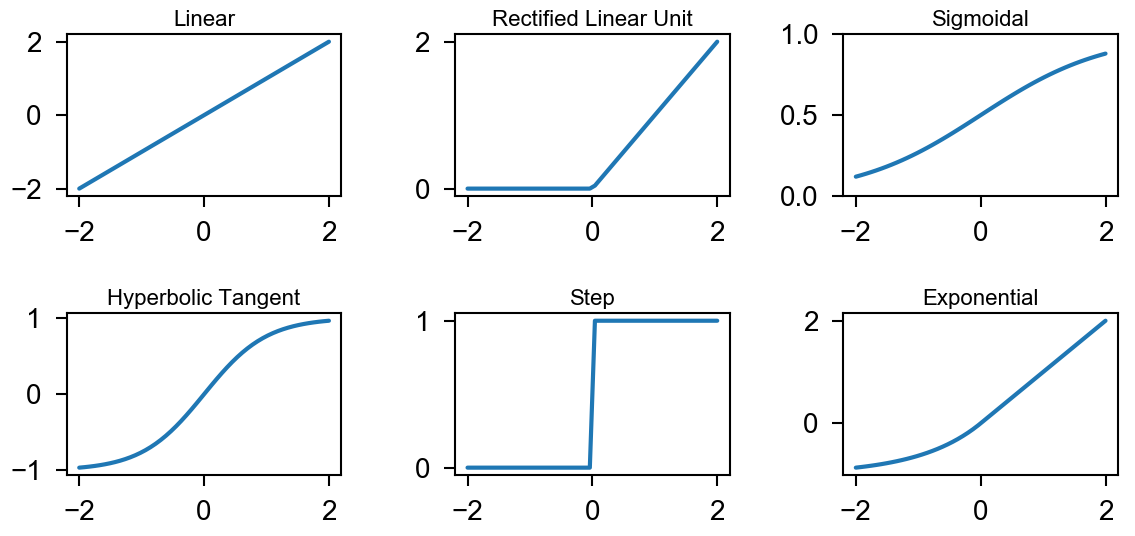

In [6]:
plot_activation_functions(np.linspace(-2, 2, 50))

The activation function that should be used on a node will depend on the problem we are trying to answer. 
Trial and error is often needed to determine which will provide the optimal results.
However, some have advantages over others. 
For example step functions were the first used in ANNs, but are less stable than the non-binary functions so they are not used as frequently today.
Hyperbolic tangent functions are typically faster to train than sigmoidal (Bishop 1995). 
The difference in training time is in part due to the sigmoidal having a value of y = 0.5 at x = 0 and the hyperbolic tangent y = 0 at x = 0, which helps distinguish cases.
Note that the hyperbolic tangent function is an offset rescaling of the sigmoidal function.
Generally, the rectified linear unit function responds better than the sigmoidal and hyperbolic tangent activation functions when there are small changes to the weights (we will address why rectified linear units are better for small weight changes when we discuss model adjustments below).

In recent years, the rectified linear unit activation function has become the most popular for most applications.
This has the functional form:

\begin{equation}
f(x) = 
\begin{cases}
x \text{  if x > 0} \\
0 \text{  if x $\leq$ 0}
\end{cases}
\end{equation}

which will set any negative values to zero and leave positive values unaffected.
The rectified linear unit is suggested to be the default activation function to use.

### Error Functions

Next, let us discuss how to calculate the error in the ANN.
There are two common methods for measuring the error in an ANN. 
The method selected will depend on whether the ANN is attempting to solve a regression or a classification problem.
In regression problems, the ANN is trying to predict a float value based on the inputs whereas in a classification problem, the ANN is attempting to assign the input into a distinct category.

In regression problems, the root mean square error is often used, in part due to its simplicity (Bishop 1995).
This equation has the form:

\begin{equation}
E_{RMS} = \sqrt{\frac{1}{N}\sum_{n=1}^N \Big(y_{p}-y_{t} \Big)^2},
\end{equation}

in which $N$ is the number of training samples, $y_{p}$ is the value predicted by the ANN and $y_{t}$ is the actual value.
Because the error is a summation, supplying the ANN with more training points per iteration will increase the error calculated. 
The presence of the square-root helps reduce the dependence of error on the training size. 
This reduced dependence leads to the root mean-square error being more commonly used than simple mean-square error.
It should also be noted that this method is also sensitive to the presence of outliers which can skew the mean error and lower the accuracy of the ANN.
As such, care must be taken to ensure that the data supplied to the ANN is clean of outliers and spurious data.

In classification problems it is more common to use cross-entropy as the error.
We will not go into depth into the cross-entropy derivation, however, cross-entropy is derived from information theory.
In this, the amount of information received from an event is proportional to its entropy, i.e. when the outcome is less certain (more entropy), we are more surprised by an answer (more information).
The cross-entropy between two probability distributions $p(x)$ and $q(x)$ is:

\begin{equation}
S = - \int p(x) lnq(x)dx,
\end{equation}

in which $p(x)$ is the true probability distribution and $q(x)$ is our proposed distribution.
The entropy will be minimized when our distribution matches the true distribution, i.e. $p(x)=q(x)$.
In training an ANN in classification, we measure and minimize the cross-entropy by determining $q(x)$.
However, because our data is not continuous, the actual error function used to train the ANN is:

\begin{equation}
E = - \sum_{n=1}^{N} \sum_{k=1}^{c} y_{t} ln y_{p},
\end{equation}

in which $N$ is the number of training samples, $c$ is the number of classes, y$_{t}$ is the true value and y$_{p}$ is the predicted value.

In these classification problems, the class to which the sample belongs is singular i.e. the sample belongs to one class and one class only.
Therefore, we often apply an additional type of activation function to the output (and only the output layer) called the softmax activation function.
The purpose of this is to assign the value to only one class by setting probability of it belonging to the chosen class to one and all other classes to zero.

### Gradient Descent

Now that we have calculated the error in our ANN, we need to change the weights and biases to reduce this error.
There are multiple algorithms that can be applied in determining how the weights and biases should be changed.
The most common one is gradient descent and calculates the changes to the weights with:

\begin{equation}
\Delta w = - \eta \nabla E,
\end{equation}

where $\eta$ is the learning rate, a hyperparameter that is chosen by the user, and $E$ is the error function (such as cross-entropy or root mean square error).
Some care must taken with choosing $\eta$. 
If $\eta$ is too small of a value, it will increase the amount of time necessary for the ANN to achieve the best weights. 
Conversely, if $\eta$ is too large it may lead to instabilities and may prevent the ANN from converging to the correct weights.
Often some trial and error is needed to verify $\eta$.

To avoid the issues with having a rigid $\eta$, other algorithms have been implemented that can vary $\eta$.
The favored one is the Adam optimizer, which stands for adaptive moment estimation (Kingma and Ba 2014).
With Adam two $\beta$ values are specified to control how $\eta$ will be changed. 
The various ANN packages have suggested, default values for $\beta$.
The Adam optimizer is suggested because it works better than simple gradient descent for noisy and sparse problems.

Because the gradient of the error function determines changes in weights, the activation function we use can become important if these changes are small.
When sigmoidal and hyperbolic tangent functions are used, the derivative of the activation function at large negative and positive values gets vanishingly small.
This can cause the "vanishing gradient problem" if there are many layers in which the changes are too small and set to zero which prevents further training.
The rectified linear unit's derivative is constant at values greater than zero, which helps avoid issues with the vanishing gradient problem (Glorot, Bordes, and Bengio).
However, an issue can also arise with the rectified linear unit with values less than and equal to zero since in this range the gradient is zero and prevents training, this is called the "dying-relu" problem.
To avoid this, a "leaky" rectified linear unit, in which a small slope is is applied on values less than zero rather than being set to zero or the exponential linear unit can be used (He et al. 2015).

### Convolution, pooling and drop out layers

Now we move into the special types of layers we can apply in our hidden layers to help with accuracy and generalization: a convolution/pooling layer and a drop out layer.
Convolutional layers are a way of making our ANN more sensitive without increasing the complexity of the ANN by adding more nodes and hidden layers, which can greatly increase training times.
A convolutional layer can be thought of as passing a moving window over our data to help identify the most important features.
This can is represented in an example: 

![title](images/conv.png)

In the example, we have a 5x5 array as our input.
We move a 2x2 window over the data which adds up the data within the window and multiplies it by 0.5.
Here the 0.5 is acting as a filter.
By conducting this convolution, we are reducing the dimensionality of the data (5x5 to 4x4), and in doing the summation and filtering trying to identify the most important features within the window.

During a convolution, we can also use multiple filters.
Each filter is adapted during the training process to identify different important features.
For example, in ANNs trained in image recognition one filter could be trained to identify edges and another shapes.
For example, if we apply ten filters to our data, from our initial 5x5 array we would create 10 4x4 arrays.
With this increase in data we often want to do another down sampling on our data to again reduce its volume while trying to identify the most important features.
This down sampling can be done with a process called pooling. 

In pooling we again apply a sliding window technique similar to the convolution, but rather than applying filters which will be determined and tuned during the training process we apply a static statistical function to the data in the window:

![title](images/pool.png)

In the image we are applying the maximum function, which is the most common function to used in pooling.
Now we have N 3x3 arrays for the N filters.
This pooling is not only able to help with the down-sampling, but also helps the ANN overcome differences in scale and orientation in the inputs.

A more in-depth tutorial on convolution and pooling is given by: [Adventure in Machine Learning: Convolutional Neural Networks Tutorial in TensorFlow](http://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/), and the reader is invited to read this resource to get a more in depth description of convolution and pooling.

The other type of layer we present here is a drop out layer.
The primary goal in implementing a drop out layer is to prevent an ANN from over fitting the training data then extrapolating poorly to future data.

![title](images/dropout.png)

As is shown in the figure, in the drop out layer random nodes within the layer are ignored and their influence on subsequent layers is removed. 
At each training iteration a different, random subset of the nodes will be dropped.
This is analogous to the ANN training with different subsets of evidence at each iteration, and helps prevent the ANN from becoming too dependent on one evidence, which results in better generalization.

## The Ising system

We turn now to the ANN example.
Here, we replicate from the work of Carrasquilla and Melko in which they train ANNs to determine if an Ising system is at a low or high-energy state based on the spins within the lattice.
They do this for two Ising systems: the square-ice model and the gauge model, which have two different Hamiltonians describing the calculation of energy.
The square-ice model is concerned with the energies of the vertices (V) shown in the following image, and the gauge model is concerned with plaquette (P) energy.

![title](images/Ising.png)

We can imagine the image as a lattice of atoms. 
The atoms reside on the lattice vertices.
Between the atoms reside the spins which can be either in the "up" or "down" position, which can be represented by the Ising system as a +1 or -1.

### Square-Ice Model

For the square-ice model, considering the vertex energies, the energy is defined by:

\begin{equation}
H_V=J \sum_V Q_V^2, 
\end{equation}

in which $J=1$ and $Q_V$ is the charge on the vertex. 
The charge on V is determines from the four spins surrounding the vertex:

\begin{equation}
Q_V = \sum_{i \epsilon V} \sigma_{i},
\end{equation}

where $\sigma_i$ is the spin value for the spin neighboring the vertex.
For example, the most central vertex would have a $Q_V$ of -2 if spin down is -1 and spin up is +1.
Looking at the Hamiltonian, we can determine that a vertex would be in the lowest energy state when the vertex is next to two up spins and two down spins $((1+1-1-1)^2=0)$.
The highest energy conformation would occur when all the spins are the same $((1+1+1+1)^2=16)$, and a medium state in which we have one spin opposite the other three $((1+1+1-1)^2=4)$.

We show an array of morphologies produced by our Monte Carlo algorithm at different temperatures (kT). 
Each plot has the temperature at which it was run and the final total temperature.
In these images black and white circles represent up and down spins and green, yellow and red circles represent vertices in low, medium and high-energy states respectively.

![title](images/square-ice-plots.png)

As we showed earlier, the vertices in high-energy states are surrounded by spins of the same type and those in low-energy states have two up and two down spins.
We can see at temperatures less than 1, every vertex is in a low-energy state.
At temperatures $1 \leq kT < 8$, we observe the presence of medium-energy vertices, but no high-energy vertices.
At temperatures $kT > 8$, we see the presence of the high-energy states.

We compare these observations with the total system energy over time and as a function of temperature.
To calculate the final energy as a function of temperature we assume the system has come to equilibrium at 1 $\times$ 10$^5$ steps, and take the average and standard deviation from this point.

![title](images/EvT-square-ice.png)

We observe that the kT = 0.1, 0.5 and 1.0 systems have quantitatively similar total potential energy.
At temperatures $kT > 1.0$, there is a larger increase in energy as a function of temperature than is seen at the low temperatures.
The rate of increase in energy as a function of temperature then begins to flatten as we continue to elevated temperatures, kT $\geq$ 8.0.
From the energy as a function of temperature, we can conclude there is a phase transition from the low-energy ground state at kT $\leq$ 1.0 to a high-energy excited state at kT $\geq$ 8.0.

With the code presented above, the user can run their own simulation with:

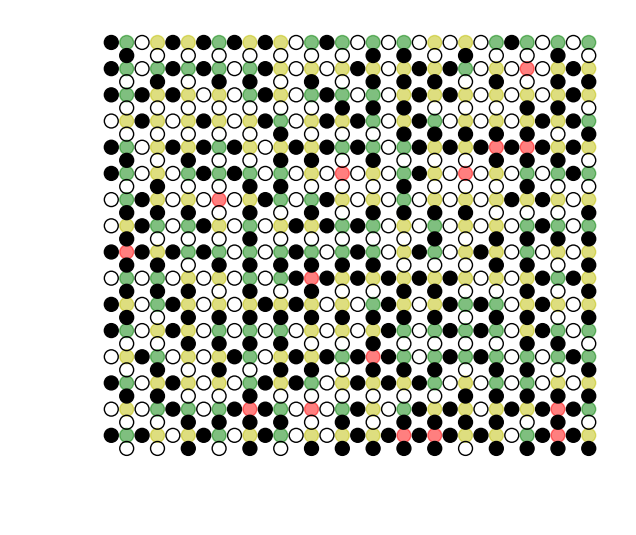

In [7]:
size = 16

vertices_to_bonds_mapper, bonds_to_vertices_mapper = build_mappers(size)
ising = Ising(size = size, seed = np.random.randint(1000000), T=30, model='square-ice')
ising.get_mappers(vertices_to_bonds_mapper, bonds_to_vertices_mapper)
ising.apply_bonds()
ising.run(2e5)
ising.plot_system()

### Gauge Model

In the gauge model we calculate the energy with:

\begin{equation}
H_P = -J \sum_P \prod_{i \epsilon p} \sigma_i,
\end{equation}

in which the energy of a plaquette is calculated by the product of the four spins $\sigma_i$ surrounding it.
The Hamiltonian shows two energetic states existing for the plaquettes.
The first involves even numbers of spins $(-1 \times (1\times 1\times 1\times 1)=-1)$, which corresponds to a low-energy plaquette.
The second involves odd number of spins $(-1 \times (1\times 1\times 1\times -1)=1)$, which results in a high-energy plaquette.

We show an array of morphologies produced by our Monte Carlo algorithm for the gauge model at different temperatures (kT). 
Each plot has the temperature at which it was run and the final total temperature.
In these images black and white circles represent up and down spins and green and red circles represent plaquettes in low and high-energy states respectively.
Note, plaquettes are shown in the same place as vertices were in the square-ice system.
The only difference in plaquette and vertex location is the indexing and, since the square-ice and gauge models are treated independently, applying the same indexing to both systems will not affect the energy calculations.

![title](images/gauge-plots.png)

In the gauge system observe that the kT=0.1 system is the only system to have no high-energy plaquettes.
At temperatures above $kT > 0.1$, we observe the number of high-energy plaquettes increases with temperature.

![title](images/EvT-gauge.png)

When we visualize the energy as a function of temperature, we see that the low-energy systems ($kT \leq 0.5$) are fairly close in energy, but at $kT > 0.5$ we observe a large increase in energy as a function of temperature.
At $kT = 8.0$, the energies begin to converge to a more constant value.
This energy-temperature behavior indicates there is a low temperature phase at $kT < 0.5$.
As the temperature increases, the system is undergoing melting until $kT = 8.0$ at which point the system is in a high-temperature, excited state.
This behavior indicates that the gauge model has a lower order-disorder transition than the square-ice model explored above.
Carrasquilla and Melko report that the system has a system-size dependent cross-over temperature defined by:

\begin{equation}
\frac{kT}{J} \approx \frac{1}{ln(\sqrt{N})} \approx 0.36,
\end{equation}

where N is the number of plaquettes and corresponds to our $kT \approx 0.5$ transition.


We can run the Monte Carlo code for the gauge system with:

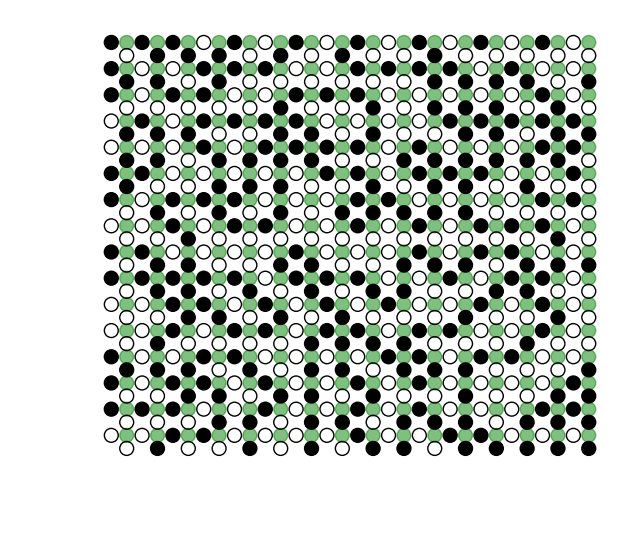

In [8]:
size = 16

vertices_to_bonds_mapper, bonds_to_vertices_mapper = build_mappers(size)
ising = Ising(size = size, seed = np.random.randint(1000000), T=0.05, model='gauge')
ising.get_mappers(vertices_to_bonds_mapper, bonds_to_vertices_mapper)
ising.apply_bonds()
ising.run(2e5)
ising.plot_system()

### Ising Data Used in the ANN

To generate the data, we use the Monte Carlo algorithm (the code is presented above). 
In this algorithm, we initialize a random Ising system with 512 spins (which corresponds to 256 vertices or plaquettes).
We equilibrate the system at a temperature of 0.1 over 10,000 trial moves for the ground-state and use random states as our excited states.
We generate a total of 20,000 training points for each model (10,000 low-energy and 10,000 high-energy) to be used by our ANN.

We deviate from the two temperatures used in the paper: 0 and $\infty$. 
This is due to the T=0 system likely having kinetic trapping occur because there is no possibility for the system to increase in energy in order to leave a local energy minimum.
This will prevent the system from reaching the global energy minimum.

We use python to visualize what these systems look like for a low-energy, ground and a high-energy, excited states, without also showing the vertices.
First for the square-ice system:

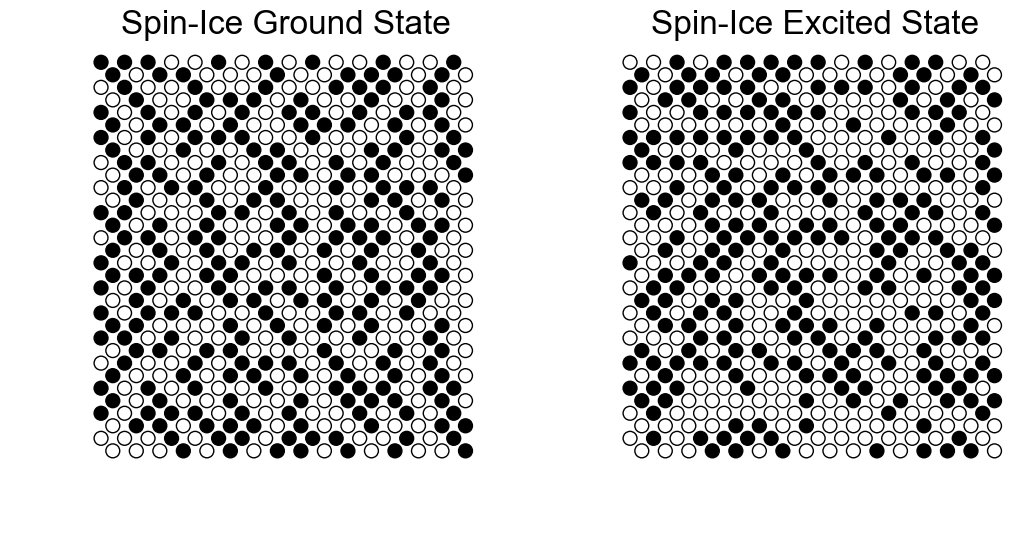

In [147]:
#Load in the ground and excited states.
ground_state = np.load('square_ice_ground.npy')
excited_state = np.load('square_ice_excited.npy')

#Select two random states.
random_state = np.random.randint(0, len(ground_state), size=2)

#Visualize the two systems.
visualize_lattice(ground_state[random_state[0]], 
                  excited_state[random_state[1]],
                  "Spin-Ice Ground State",
                  "Spin-Ice Excited State")

We check the arrays of spins that are present in our training and test set to make sure there are no odd values with the function presented at the top of the workbook.
This function checks for incorrect spins and vertex energies.

In [156]:
verify_inputs(excited_state, ground_state, model='square-ice')

The ground state systems have a mean of 2.53 +/- 3.72
The excited state systems have a mean of 1024.52 +/- 78.87


Our function didn't find any data points within the dataset that violated the rules for what spins and vertex energies are allowed.
The ground and excited states also show significant difference in their average energies.

Based on the Hamiltonian, a vertex has the lowest energy when it is next to two up spins and two down spins.
If we compare the two states visually, there is perhaps more clumps of spins (which is a higher energy conformation) in the excited state than that in the ground state, which has lines of same spins.
However, because the energy calculation is done not by the spins directly, but their summation around the vertices, it is difficult to tell which is the higher energy state without knowing the lattice of vertices.

Now the gauge system:

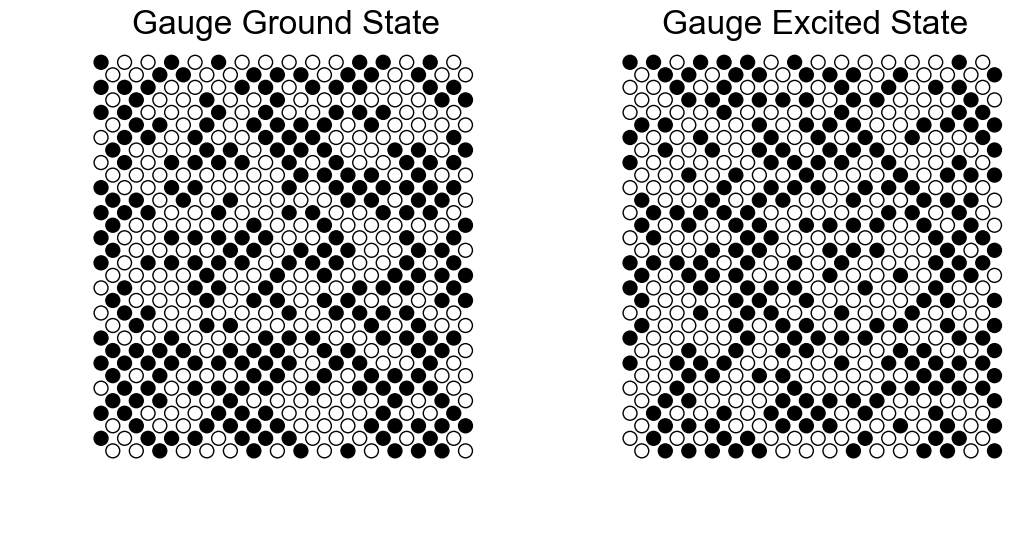

In [149]:
#Load in the ground and excited states for the gauge system.
gauge_ground_state = np.load('gauge_ground.npy')
gauge_excited_state = np.load('gauge_excited.npy')

#Select two random states.
random_state = np.random.randint(0, len(gauge_ground_state), size=2)

#Visualize the two systems.
visualize_lattice(gauge_ground_state[random_state[0]],
                  gauge_excited_state[random_state[1]], 
                  "Gauge Ground State", 
                  "Gauge Excited State")

In the gauge model, a plaquette has the lowest energy when it has an even number of adjacent even and odd spins.
Both excited and ground states have visually similar aggregation.
Again, it is difficult to determine which system is in a high-energy and which is in a low-energy state without knowing the plaquette lattice.

We verify the data in the arrays by using our function at the top to make sure no unexpected values are present.

In [157]:
verify_inputs(gauge_excited_state, gauge_ground_state, model='gauge')

The ground state systems have a mean of -255.22 +/- 1.58
The excited state systems have a mean of 0.32 +/- 15.87


No strange spins, i.e. not +1 or -1 were found. Additionally all plaquette energies were the allowed +1 and -1.
There is a large separation between our excited and ground states.
With the data conforming to what's expected, we shouldn't be producing errors in our ANNs because of spurious data points.

## Artificial Neural Net Walk Through 

Now let us move into preparing the ANN to train on these systems.
To set up and train the ANNs we follow the general procedure:

1. Prepare training data and testing data.
  * This includes formatting the data in the correct shape.
  * This may also include normalizing the data by taking the mean, standard deviation, etc.
2. Build the ANN toplogy.
3. Set up the matrix operations for adding, multiplying and applying activation functions on the weights and biases presented in 2. 
4. Select an error function.
5. Determine how to minimize the error. 
6. Conduct N training iterations from the training data.
7. Evaluate the accuracy of the ANN on the testing data.

We will walk through the steps above and show how we apply them for our Ising systems. 
For readability, we do not show the full code here, only snippets containing the most pertinent portions.
The full code is present at the top of the work book.

### Step 1

The first step is to load in the data.
Here we have the excited state and ground state datasets in two separate files.
Each file contains 10,000 binary arrays of length 512.
We generate labels for the systems based on if it is in the ground state or excited state.
To signify ground state we create an array of length two where the the non-zero entry signifies the state, e.g. [0, 1] for excited and [1, 0] for ground states.
We also shuffle the order of the arrays, so that each time we train the ANN it's seeing a different subset of the data.
This results in two arrays of shape [20,000, 512] and [20,000, 2], from which we use 16,000 as training data and the other 4,000 as testing data.

Note: Because our systems here are binary we do not have to do normalization on the dataset to assist the ANN in the training process.
However, for many other materials-related scenarios normalizing the data is likely necessary.
There are multiple ways of treating the data, including feature extraction (in which representative values are calculated from the raw-data), dimensionality reduction (in which the ANN is only provided a subset of the inputs), and normalization (where averages and standard deviations are applied to the data to restrict the range).
The process of normalizing data and feature extraction is a large challenge in training various forms of machine learning and is beyond the scope covered here.

### Step 2

For step 2 we need to set up the weights with their connections.
For tensorflow, we do this by setting up the weights in a function:

```python
def weights(in_size, out_size):
    #Set up weights and biases.
    W = tf.random_normal(shape=[in_size, out_size], stddev=0.01)
    b = tf.random_normal(shape=[out_size], stddev = 0.01)
    W, b = tf.Variable(W), tf.Variable(b)
```

In the square-ice ANN we default to three layers: the input layer, one hidden layer and an out layer.
This means we have two sets of weights that be used to connect our three layers.
For this we assign the weights an "in size" and and "out size" for their shape.
For the first layer the "in size" will be 512 because we have 512 points in each array.
The "out size" here is variable is the number of nodes our hidden layer.

For the second layer of weights, the "in size" is now the number of nodes in the hidden layer.
The "out size" of the final layer must equal the number of classes we have, in this case two.

To initialize these weights, we assign them random values taken from a Gaussian distribution with a mean of zero and standard deviation of 0.01.
There are other initial values we can use to assign them.
For example, in the previous work of assigning time series of potential energy as high or low-energy we initialize them all as zero.
However, trying to initialize them as zero in this system prevented the ANN from training, therefore care must be taken in selecting these initial weights.

In training the ANN these weights and biases will be changed until the matrix operations produce the correct result.
When using tensorflow, we must tell tensorflow that they can be changed. 
We do this by calling the tensorflow function tf.Variable() on them as is seen in the code snippet.

### Step 3

For step 3 we need to set up the mathematical operations we are doing to our matrices.
Again we create a function to do this for us:

```python
def layers(x,W,b):
    return tf.nn.relu(tf.matmul(x,W)+b)
```

In this function, we are taking our input x and multiplying them by the node weights W by calling the tensorflow function tf.matmul().
We then add the biases of the nodes to the multiplied matrix.

Next, we apply our activation function to the nodes by calling the function from tensorflow.
We default to the rectified linear unit activation function.
We can use other activation functions: sigmoidal (tf.nn.sigmoid), hyperbolic tangent (tf.nn.tanh), exponential (tf.nn.elu) or no activation function.
Note, tensorflow doesn't natively support step functions. 
A user can create an approximate one by multiplying the sigmoidal activation function by a large number, e.g. 10000 $\times$ tf.nn.sigmoid().

If we set up a convolutional layer in our ANN, we will need to make some extra steps.
There are a number of convolutional layers that are built into tensorflow, based on the dimensionality of the input data. 
Our Ising system is in two dimensions so we use the 2D convolution function:

```python
tf.nn.conv2d(input, filter, strides, padding)
```

The convolution function requires four arguments: the input- the data array, the filter, the stride - how we move the window through the input, and the padding - how we treat data on the edges of the array.
We don't cover the complete implementation of the function here, for that the reader is encouraged to read through [this tutorial](http://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/).
However, it will be worthwhile to discuss how we build a the filters.

We create our own filter similar to how we created weights for the hidden layers.
For a filter we use a 4x1 vector where the values are: number of rows, number of columns, number of channels, number of filter weights.

```python
filter = tf.Variable(tf.random_normal([number of rows,
                                       number of columns,
                                       number of channels,
                                       number of filters]))
```

The filter dimensions depend on our input data (for our Ising system they are 32 and 16 or 33 and 17 if we have periodic boundaries specified).

The number of channels depends on the depth of our data, which is best understood with an example.
If our input were a colored picture, we would have red, green and blue pixels. 
Each of these pixel colors would be considered a channel that can be considered separately.
Here we only have 1 channel since they are only positive or negative ones, and most problems will only involve one channel.

For the final filter input, we choose the number of filter weights we want to apply, which is similar to choosing the number of nodes we desire in a hidden layer, and requires some trial and error in optimizing.
We do not need to worry about selecting a value for the filter weight, rather this will be determined during the training process.

### Step 4 ###

In step 4 we need to tell the ANN how to measure the error between what the actual results are and what the ANN predicts.
Here we are trying to classify the system as low or high-energy so we will use the cross entropy rather than mean-square error.

```python
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_final))
```

In the snippet, we are telling tensorflow to reduce the error from the softmax, cross entropy.
The "logits" is telling tensorflow that these are unscaled log probabilities, which must be chosen when we use the cross-entropy in tensorflow.
Lastly, we are giving the ANN the y\_final which is what the ANN predicts the values to be and the true labels y_.

### Step 5

In determining how to minimize the error we use the gradient descent.
Implementing the gradient descent algorithm can be done with the code:

```python
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
```

In the snippet, we are defining a training step as using the gradient descent optimizer to minimize the cross entropy with a learning rate, $\eta$ of 0.5.

### Step 6

Now that we have the topology for the ANN set up, we can begin the training process.
If we are using tensorflow, we need to first create a tensorflow session:
```python
    session = tf.Session()
    session.run(tf.global_variables_initializer())
```

Since we are doing supervised learning in this example, we need to repeatedly run the ANN with the training step created in Step 5, input vectors and the answers.
We can do this in a loop where the inputs and answers are supplied via a dictionary:
```python
    for _ in range(training_iterations):
        batch_vectors, batch_labels = get_batch(train_vectors, train_labels)
        session.run(train_step, feed_dict={x:batch_vectors, y_:batch_labels})
```

In this example, we are using a batch learning method.
On each training iteration we supply the ANN with 100 random examples from the training dataset.
In this example, if we do not do a batch learning method, rather gave the ANN the full set of data at each iteration, then the ANN quickly over fit the training data and extrapolated poorly to the test data.

Over fitting can be an issue in training ANNs.
There are various methods to prevent overfitting.
One method is "early stopping".
In early stopping, we measure the accuracy of the ANN in predicting the training data (we will cover how to assess the accuracy in the next step).
When the ANN is above a chosen threshold we terminate the training process thereby preventing further adaptation of the weights.
In this example we use a threshold of 99.0% accuracy.

### Step 7

We want to now evaluate how well our ANN extrapolates to the test data.
To do this, we first create a comparison:

```python
    #Set up the comparison
    comparison = tf.equal(tf.argmax(y_final, dimension=1), tf.argmax(y_, dimension=1))
    correct = tf.reduce_mean(tf.cast(comparison, tf.float32))
```

The tensorflow function tf.equal() determines if the prediction is the same as the actual value.
The tensorflow cast function tf.cast() is then used to change the values from tf.equal() to ones or zeros.
Lastly, the reduce_mean calculates the average value of the array, which corresponds to the ratio of correct values.

We now run the ANN on the validation data and the comparison we set up:

```python
    #Evaluate the trained ANN with the validation dataset.
    accuracy = session.run(correct, feed_dict = {x:validation_vectors, y_:validation_labels})
```

In doing this, we determine what fraction of the data was guessed correctly.
Note: In tensorflow, calling the ANN on our training step and validation step is the same process, the difference is in what we are passing the session.run() function.

## Running and Evaluating the ANN

We now turn to testing the ANN.
The ANN has been set up to be flexible and allow the user to make changes when calling the function.

```python
def run_NN(vectors, 
           labels, 
           n_layers = 3, 
           n_nodes = [512, 252, 2], 
           training_iterations= 1e5, 
           activation_function =["relu","relu"], 
           convolution = False,
           nfilters = None,
           periodic = False,
           drop_out_layer = True):
```

The vectors and labels are required when calling the run_NN() function, and these arrays can be obtained with the help of the get_input_data() function (no arguments required).
The number of layers (n_layers), number of nodes in each layer (n_nodes), training_iterations, activation functions (activation_function), and convolution can all be varied.
The default variables are shown in the code snippet.
The number of layers must be greater than or equal to two (one input layer and one output layer).
The number of nodes in the first layer must be 512, equal to the number of inputs in the vector and the number of nodes in the final layer must be equal to two, equal to the number of classes.
The number of training iterations can be any integer greater than 1,000.
The activation function is a list of strings and has a length of number of layers - 1.
The activation functions supported are: relu (rectified linear unit), sigmoid, tanh (hyperbolic tangent), step, elu (exponential), and linear (which is the same as no activation function).
We can also specify if we want a covolutional layer and how many filters we want to use in the convolution.
There are also options for if we want the boundaries to be periodic and if we want to use a drop out layer when we do the convolution. 
Note: periodic boundaries can only be done when doing convolution on the guage system.

The full code is presented at the top of the workbook.
Now that we have set up the ANN, let's run the ANN and see how well it performs.
For this first step we don't use convolutional layer:

In [85]:
vectors, labels = get_input_data()
run_NN(vectors, labels)

Training the ANN to distinguish excited and ground state system.
Setting up the artificial neural net toplology.
Initializing the Tensorflow session.
Beginning the training process.
0.49333334
0.99983335
Finished training. Validating against the test dataset.
The ANN had a 99.10000% accuracy on the test dataset.


From this we see that our ANN is able to distinguish the states ~ 99% of the time with the default ANN settings, and (depending on the workstation run on) takes only a few seconds to reach this accuracy.
The user is invited to play with the ANN options to see how the accuracy and training times change with the different parameters.

This result is comparable to those obtained by Carrasquilla and Melko, who also obtained accuracies of 99%.

We now turn to how our ANN works for the gauge system.
When we naively apply our earlier ANN to the gauge system we get:

In [99]:
vectors, labels = get_input_data(ground ='gauge_ground.npy', excited = 'gauge_excited.npy')
run_NN(vectors, labels)

Training the ANN to distinguish excited and ground state system.
Setting up the artificial neural net toplology.
Initializing the Tensorflow session.
Beginning the training process.
0.5006667
0.99972224
Finished training. Validating against the test dataset.
The ANN had a 97.85000% accuracy on the test dataset.


The ANN obtains ~ 98% accuracies on the test set.
This results is much higher than that obtained by Carrasquilla and Melko, who obtained an accuracy of 50%.
One difference in the ANNs is we apply a rectified linear unit, whereas Carrasquilla and Melko used a sigmoidal activation function, which when we use a sigmoidal activation function trains more slowly and doesn't obtain as high of accuracies (~80%).
Despite this, we note that there may be some underlying difference in the data generated with our Monte Carlo algorithm and the data used by Carrasquilla and Melko, which may be responsible for the deviation is accuracy.

When we consider how to increase the accuracy of our ANN further, we notice the ANN is able to get > 99% accuracy on the training data.
However, the accuracy is ~ 98% on the test dataset, which means the ANN is fitting the testing data and not learning the underlying pattern sufficiently to extrapolate to the test data and obtain the same accuracy.

To fix this over fitting we apply three major changes: convolution and pooling, a drop out layer, and periodic boundaries.
The convolution and pooling is implemented so that the ANN will train on the important underlying pattern in the data, not the exact data points.
The periodic boundaries are primarily implemented to help with the convolution.
In the convolution, we know that our system is 32 x 16 spins for the 16 x 16 plaquettes.
However, the energy for the plaquettes along the edges will be affected by the spins on the opposite side of the array.
To make sure we capture this, we add the periodic boundary conditions while sliding our convolution window.
Note, we saved the arrays with periodic boundaries in separate files so that the periodic boundaries don't need to be calculated as frequently since it is slow.

In [94]:
vectors, labels = get_input_data(ground ='periodic_gauge_ground.npy', excited = 'periodic_gauge_excited.npy')
run_NN(vectors, labels, 
       n_layers = 3, 
       n_nodes = [561, 252, 2], 
       activation_function = ['sigmoid', 'sigmoid'], 
       training_iterations=2e4,
       convolution = True,
       n_filters = 60,
       periodic = True,
      drop_out_layer = True)

Training the ANN to distinguish excited and ground state system.
Setting up the artificial neural net toplology.
Initializing the Tensorflow session.
Beginning the training process.
0.49911112
0.5008889
0.49927777
0.6281667
0.50116664
0.68777776
0.61716664
0.6516111
0.6880556
0.73672223
0.73483336
0.7608889
0.7800556
0.7134445
0.8104445
0.8638333
0.9158889
0.9401111
0.8271111
0.95383334
0.98233336
0.9829444
0.98777777
0.98811114
0.9903333
0.9917778
0.9915
0.992
0.9918333
0.9923889
0.9927222
0.99322224
0.99344444
0.99333334
0.9936111
0.99383336
0.99366665
0.99483335
0.99483335
0.99444443
0.9958889
Finished training. Validating against the test dataset.
The ANN had a 99.10000% accuracy on the test dataset.


With these implementations we are able to get and improvement of 1% and obtain accuracies of ~ 99%.
When we run the system with convolution, periodic boundaries, and a drop out layer, our ANN trains much more slowly because of the additional features that must be trained.
However, this improvement shows how the convolution/pooling/drop out is able to help increase the accuracies of ANNs.

In Carrasquilla and Melko's work, they obtained accuracies of 100% when they apply convolution. 
They indicate that their ANN distinguished between the excited and ground states by the presence of a single high-energy plaquette.
We however, have some low-energy plaquettes that aren't at the absolute minimum since we do not run at kT = 0.0, rather at kT = 0.1 which would allow for some deviation from the absolute minimum.
We also note that there may be some difference in our data set compared to Carrasquilla and Melko's, which may be responsible for the difference.

## Applying Artificial Neural Nets to Other Materials Problems

We have gone through the examples of the relative simple square-ice, and more complex gauge models for the Ising system.
When constructing the ANNs to answer other materials problems, it is relatively fast to throw an ANN together, however optimizing the ANN and obtaining good predictions can take considerable time.
Additionally, when we have overly complex models, our ANN will tend to over-fit the training data.
In general, it is best to start with a relatively simple network (no hidden layers, and a rectified linear unit activation function) and then build in complexity.

In doing this optimization, because there are various parameters that can be tuned, it is suggested to make the ANN flexible so that these parameters can be more quickly explored.
For example, we allow the various activation functions to be selected in the function call for our example ANN.
This allows for the construction of loops which will call the ANN with different parameters, and allows for automation of the trial and error testing process.

Other challenges in applying ANNs to materials problems include overcoming the "curse of dimensionality" and having sufficient training data.
The curse of dimensionality describes the exponential relationship between number of training iterations necessary and the dimensionality of the problem.
This can partially be overcome with the use of convolution and pooling to help identify the most important features, however, normalizing and preparing input data can greatly increase accuracy and decrease training times.
Additionally, data preparation is often also required to remove spurious data points which may hinder the training of the ANNs.
When trying to apply materials problems, it is also necessary to have a broad enough pool of training examples.
Without sufficient examples in training, the ANN is likely to over fit the training set and extrapolate poorly to new data, especially if the ANN is complex.
Generating this much data can be a challenge if slow experimental processes are required.

## Conclusion

We have presented an example of an ANN able to distinguish ground and excited systems for the square-ice and gauge Ising models.
We have shown with a relatively simple ANN we are able to obtain accuracies of ~100% for the square-ice model.
We have also shown how convolution, pooling and drop out layers helped the training process with the gauge model.

In applying ANNs to materials problems, one must consider how to limit the dimensionality of the input data by conducting normalization and feature extraction.
A large challenge can arise if the ANN is over-fit to the training data.
To overcome this challenge, one must provide the ANN with sufficiently diverse training data so the ANN is able to determine the underlying pattern linking inputs and outputs.
ANN construction can help alleviate over-fitting by stopping when a certain accuracy on the training data is obtained, using convolution/pooling/drop out layers and having simple ANN topolgies.
Regardless, significant trial and error is often needed to optimize the ANN and the ANN should always be verified by a test dataset external from the training set.

## References

Artrith, N; Urban, A. 2016. “An Implementation of Artificial Neural-Network Potentials for Atomistic Materials Simulations: Performance for TiO2.” Computational Materials Science 114: 135–50.

Bhadeshia, H. K. D. H. 1999. “Neural Networks in Materials Science.” ISIJ International 39 (10): 966–79.

Carrasquilla, J; Melko, R. G. 2017. “Machine Learning Phases of Matter.” Nature Physics 13, 431–434.

El-Telbany, M. E. 2014. “What Quantile Regression Neural Networks Tell Us About Prediction of Drug Activities.” Computer Engineering Conference, 2014 10th International, 76–80.

Fayos, J.; Infantes, L.; Cano, F. H. 2005. “Neural Network Prediction of Secondary Structure in Crystals: Hydrogen-Bond Systems in Pyrazole Derivatives.” Crystal Growth and Design 5 (1): 191–200. 

Glorot, X.; Antoine B.; and Yoshua B. “Deep Sparse Rectiﬁer Neural Networks,” 9.

Gomes, C. R.; Canedo Medeiros, J. A. C. 2015. “Neural Network of Gaussian Radial Basis Functions Applied to the Problem of Identification of Nuclear Accidents in a PWR Nuclear Power Plant.” Annals of Nuclear Energy 77: 285–93. 

He, K.; Zhang, X.; Ren, S.; Sun, J. 2015. “Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.” arXiv:1502.01852.

Bishop, Christopher 1995, "Neural Networks for Pattern Recognition."

Kingma, D. P.; Ba, J. 2014. “Adam: A Method for Stochastic Optimization.” arXiv:1412.6980.

Lorenz, S.; Gross, A.; Scheffler, M. 2004. “Representing High-Dimensional Potential-Energy Surfaces for Reactions at Surfaces by Neural Networks.” Chemical Physics Letters 395 (4-6): 210–15.

McCormick, T. H.; Ferrell, R.; Karr, A. F.; Ryan, P. B. 2010. “Complex Networks as a Unified Framework for Descriptive Analysis and Predictive Modeling in Climate Science.” Science And Technology 4 (5): 497–511.

Messai, A.; Mellit, A.; Abdellani, I.; Pavan, A. M. 2015. “On-Line Fault Detection of a Fuel Rod Temperature Measurement Sensor in a Nuclear Reactor Core Using ANNs.” Progress in Nuclear Energy 79: 8–21. 

Ihom, A. P.; Offiong, A. 2015. “Neural Networks in Materials Science and Engineering: A Review of Salient Issues” 3 (7): 40–54.

Oh, K. S.; Jung, K. 2004. “GPU Implementation of Neural Networks.” Pattern Recognition 37 (6): 1311–14.

Ramsundar, B.; Kearnes, S.; Riley, P.; Webster, D.; Konerding, D.; Pande, V. 2015. “Massively Multitask Networks for Drug Discovery.”

Reinhart, W. F.; Long, A. W.; Howard, M. P.; Ferguson, A. L.; Panagiotopoulos, A. Z. 2017. “Machine Learning for Autonomous Crystal Structure Identification.” Soft Matter 13 (27): 4733–45.

Singh, M.; Kaur, H. 2016. “Artificial Neural Networks in Materials Science Research.” Current Reports on Science and Technology 2 (1): 145–59.